<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/08_ViT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup and Data Loading

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
  from torchmetrics import Accuracy
except:
  print('[INFO] Installing torchinfo and torchmetrics')
  !pip install -q torchinfo
  !pip install torchmetrics

[INFO] Installing torchinfo and torchmetrics
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.7 MB/s eta 0:00:00


In [2]:
# importing python scripts and various functions from github
try:
  from modualr_pytorch import data_setup, engine, get_data
except:
  print('[INFO] Downloading scripts from github...')
  !git clone https://github.com/aashu-0/learn-pytorch
  !mv learn-pytorch/modualr_pytorch .
  !rm -rf learn-pytorch
  from modualr_pytorch import data_setup, engine, get_data

[INFO] Downloading scripts from github...
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 87 (delta 32), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 47.16 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (32/32), done.
data/pizza_steak_sushi does not exists...creating one
Downloading....the github zip file
Unzipping the zip file


In [3]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Get Data

In [4]:
# loading data using get_data.py script

train_dir = get_data.image_path/'train'
test_dir = get_data.image_path/'test'

### Datasets and DataLoaders

#### transforms for image

In [5]:
# as per vit paper the training resolution is 224 x 224

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

#### dataloaders

as per paper
- batch size = 4096
but we consider 32 why??  gpu poor :(

In [6]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform= manual_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ae24ff13790>,
 ['pizza', 'steak', 'sushi'])

#### visualize a image

In [7]:
# batch of image
batch_img, batch_label = next(iter(train_dataloader))

# single image and label
img, label = batch_img[0], batch_label[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

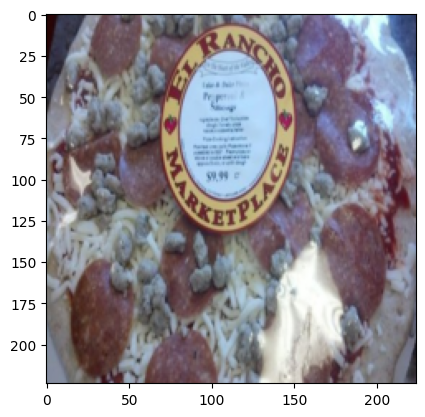

In [8]:
# let' plot an image first and the try to visualize patching
img_ = img.permute(1,2,0)

plt.figure()
plt.imshow(img_);

### 1. Equation 1: Split data into patches and creating a class, position and patch embedding
\begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned}

Image ---> flattened 2D patches ---> maps to `D` dimensions with trainable linear projection

- Image : ( H X W X C ) -> `(height, width, channels)`

- flattened 2d patches : converting each patch (`16 x 16` matrix) into 1D vector (`16 x 16 x 3`)

- linear projection : linear transforming patches to a standard size that fits the model's latent vector size `D`.

- `D` : latent vector size -> all the data points processed by the transformer is to be represented as `D` dimension vectors.

 - image --->  patches

 - `(H X W C)` ---> `(N X (P².C))`

 where  N: no of patches = `(H x W)/P²`

#### patch embedding input and output shapes

In [9]:
#calculating the no of patches using equations

height = 224
width = 224
color_channels = 3
patch_size = 16

num_of_patches = int((height*width) / (patch_size**2))
print(f'Number of Patches per image: {num_of_patches}')

Number of Patches per image: 196


In [10]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# output
embedding_layer_output_shape = (num_of_patches, patch_size ** 2* color_channels)

print(f'Input shape of single image: {embedding_layer_input_shape}')
print(f'Output shape (of 2d imge flattened into patches): {embedding_layer_output_shape}')

Input shape of single image: (224, 224, 3)
Output shape (of 2d imge flattened into patches): (196, 768)


#### Visualize single image into patches

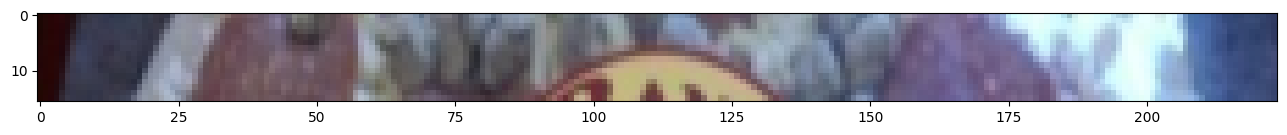

In [11]:
# let' plot an image first and the try to visualize patching
img_permuted = img.permute(1,2,0)

patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(img_permuted[:patch_size , : ,: ])
plt.axis();

In [12]:
img_permuted.shape

torch.Size([224, 224, 3])

Number of patches per row: 14.0


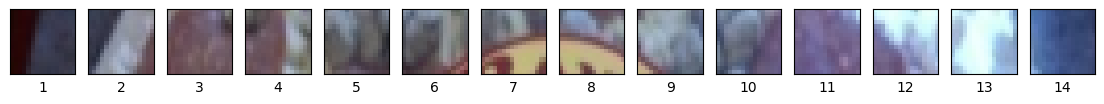

In [13]:
# we got the one row( topmost)
# divide it into patches
# num_patches -> number of patches per row
# dimensions of each patches -> (224 X 224)

img_size = 224
patch_size = 16
num_patches = img_size/ patch_size

assert img_size% patch_size ==0
print(f'Number of patches per row: {num_patches}')

# subplots
fig, axes = plt.subplots(nrows =1,
                         ncols= img_size// patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)

# iterate
for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

no. of patches per row: 14.0      
no. of patches per column: 14.0      
total patches: 196.0      
patch dim: 16 x 16


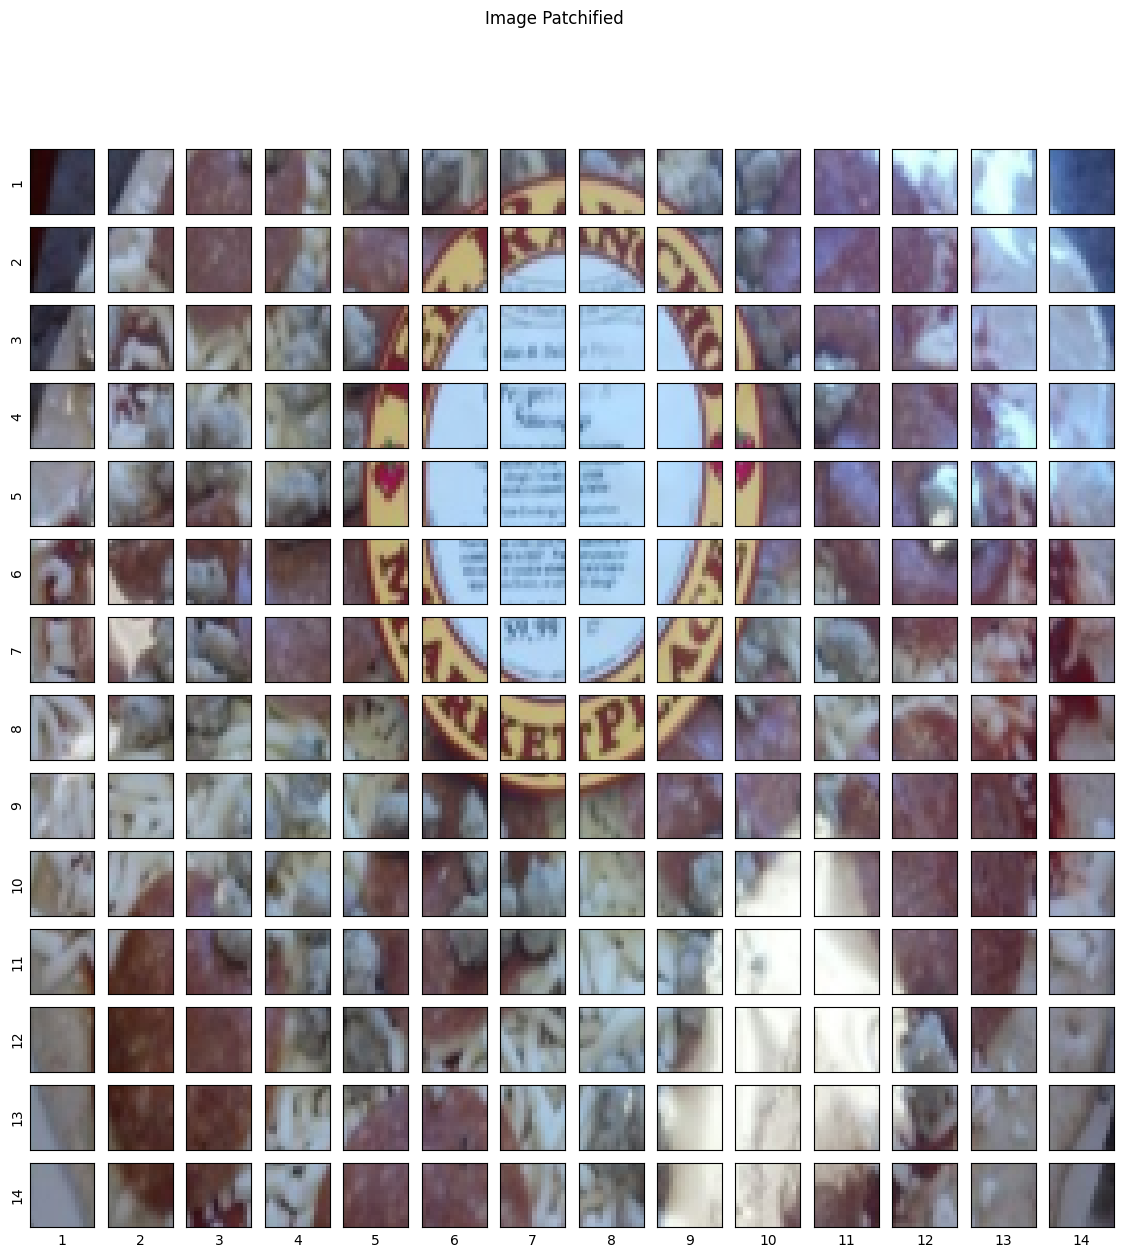

In [14]:
# let's do the same for complete image

img_size = 224

patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size ==0
print(f'no. of patches per row: {num_patches}\
      \nno. of patches per column: {num_patches}\
      \ntotal patches: {num_patches*num_patches}\
      \npatch dim: {patch_size} x {patch_size}')

#subplots
fig, axes = plt.subplots(nrows= img_size//patch_size,
                         ncols= img_size// patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)

for i, patch_height in enumerate(range(0,img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0,img_size, patch_size)): # iterate through width

    axes[i,j].imshow(img_permuted[patch_height:patch_height+patch_size, #height
                                  patch_width: patch_width+patch_size,  # width
                                  :]) # color channels

    axes[i,j].set_ylabel(i+1)
    axes[i,j].set_xlabel(j+1)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i, j].label_outer()

fig.suptitle(f'Image Patchified')
plt.show()

#### creating image patches `torch.nn.Conv2d()`

we obtain the patch embedding using CNN layer
- CNN layer extracts feature maps from the image

as per paper, instead of using raw image patches, we can use a CNN feature map
and then these feature maps are treated as patches

feature maps -> weights/activations produced by a cnn layer passing over a given image

why `kernel_size` = `stride` = `patch_size` that is 16 ?
- layer -> patches -> learnable embedding for each patch

In [15]:
# convolutional layer

from torch import nn

patch_size = 16

#conv2d layer -> images into feature maps patches
conv2d = nn.Conv2d(in_channels=3,
                   out_channels= 768,  # as per ViT Base embedding dim = 768(D)
                   kernel_size=patch_size,  # size of the filter
                   stride=patch_size, # num of steps filter moves
                   padding=0) # no padding

pass single img to conv layer

Original Image Shape: torch.Size([224, 224, 3]), Image through the conv layer: torch.Size([1, 768, 14, 14])



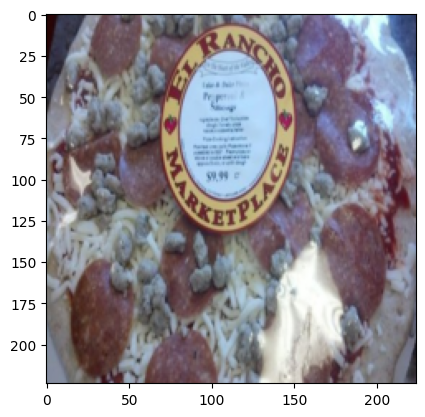

In [16]:
# original shape
org_img = img.permute(1,2,0)

#pass to conv layer
img_from_conv = conv2d(img.unsqueeze(0)) # add batch dim

print(f'Original Image Shape: {org_img.shape}, Image through the conv layer: {img_from_conv.shape}\n')
plt.imshow(org_img);

```
[1, 768, 14, 14] -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

[509, 757, 387, 321, 667]


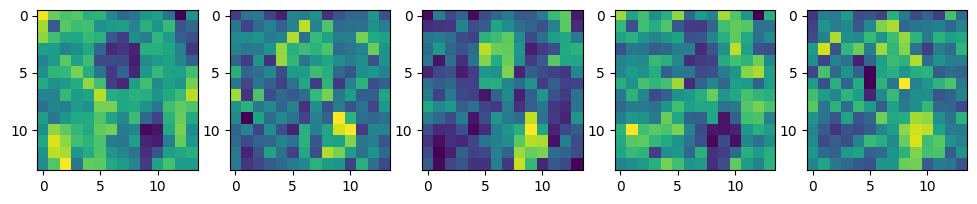

In [17]:
# let's visualize random conv feature maps

import random
random_idx = random.sample(range(0,758), k=5)
print(random_idx)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_idx):
  img_conv_feature_map= img_from_conv[:,idx,:,:]
  # print(img_conv_feature_map)
  # print(img_conv_feature_map.shape) -> [1,14,14]
  #-> gives a tensor with gradient enabled (requires_grad = True)

  # but matplotlib excepts a numpy array
  # also .numpy() only works on tensor without gradient tracking -> so .detach()
  # .squeeze() -> to make matplotlib happy hehe!!

  axes[i].imshow(img_conv_feature_map.squeeze().detach().numpy())

In [18]:
#let's see one of feature map in tensor
img_from_conv[:,0,:,:]

tensor([[[-1.0905e-02,  9.8753e-02,  1.3014e-01,  7.3197e-02,  2.1275e-01,
           1.1815e-01,  1.1552e-01,  2.8103e-01,  1.6028e-01,  2.0298e-01,
           1.2379e-01,  1.5906e-01,  4.1548e-01,  2.6510e-01],
         [ 2.1496e-02,  2.9177e-01,  8.4900e-02,  7.9491e-02,  7.9711e-02,
           2.4831e-01,  1.9933e-01,  3.3714e-01,  2.4140e-01,  2.2374e-01,
           1.4414e-01,  8.8367e-02,  2.7138e-01,  3.3681e-01],
         [-2.6667e-02,  9.6786e-02,  2.2636e-01,  2.2292e-01,  9.6941e-02,
           6.8064e-02,  3.7474e-01,  3.3810e-01,  3.1884e-01,  2.5040e-01,
           1.6991e-01,  9.2063e-02,  2.8818e-01,  4.0050e-01],
         [ 1.4979e-01,  1.8296e-01,  1.7923e-01,  2.6425e-01,  2.1338e-02,
           2.1883e-01,  3.5916e-01,  3.5313e-01,  4.0084e-01,  1.5179e-01,
           2.1810e-01,  1.6020e-01,  1.4376e-01,  3.3576e-01],
         [ 2.2337e-01,  2.3383e-01,  1.5305e-02,  1.6539e-01,  2.6224e-02,
           2.8654e-01,  3.4304e-01,  2.8098e-01,  4.2565e-01,  2.7448e-01

In [19]:
img_from_conv.shape

torch.Size([1, 768, 14, 14])

####`nn.Flatten()`
turn patch *embeddings* obtained from `conv` layer into desired output shape i.e (196,768)

In [20]:
# flatten layer
flatten = nn.Flatten(start_dim=2, end_dim=3)
flatten(img_from_conv).shape

torch.Size([1, 768, 196])

original image shape: torch.Size([3, 224, 224])
feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


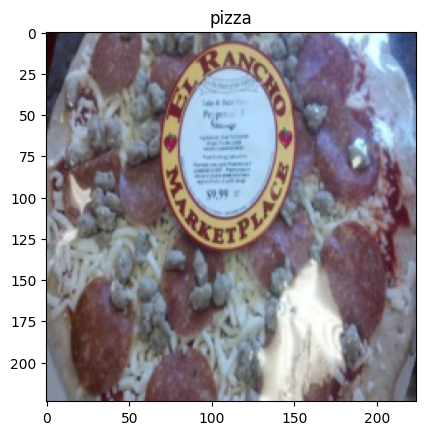

In [21]:
# sum it up

plt.imshow(img.permute(1,2,0));
plt.title(class_names[label])
print(f'original image shape: {img.shape}')

print(f'feature map shape: {img_from_conv.shape}')

img_from_conv_flatten = flatten(img_from_conv)
print(f'Flattened image feature map shape: {img_from_conv_flatten.shape}')

In [22]:
img_from_conv_flatten_reshape = img_from_conv_flatten.permute(0,2,1)
img_from_conv_flatten_reshape.shape

torch.Size([1, 196, 768])

In [23]:
# visulaize the flattened faeture map as tensor

img_flattened_feature_map = img_from_conv_flatten_reshape[:,:,0]

img_flattened_feature_map

tensor([[-1.0905e-02,  9.8753e-02,  1.3014e-01,  7.3197e-02,  2.1275e-01,
          1.1815e-01,  1.1552e-01,  2.8103e-01,  1.6028e-01,  2.0298e-01,
          1.2379e-01,  1.5906e-01,  4.1548e-01,  2.6510e-01,  2.1496e-02,
          2.9177e-01,  8.4900e-02,  7.9491e-02,  7.9711e-02,  2.4831e-01,
          1.9933e-01,  3.3714e-01,  2.4140e-01,  2.2374e-01,  1.4414e-01,
          8.8367e-02,  2.7138e-01,  3.3681e-01, -2.6667e-02,  9.6786e-02,
          2.2636e-01,  2.2292e-01,  9.6941e-02,  6.8064e-02,  3.7474e-01,
          3.3810e-01,  3.1884e-01,  2.5040e-01,  1.6991e-01,  9.2063e-02,
          2.8818e-01,  4.0050e-01,  1.4979e-01,  1.8296e-01,  1.7923e-01,
          2.6425e-01,  2.1338e-02,  2.1883e-01,  3.5916e-01,  3.5313e-01,
          4.0084e-01,  1.5179e-01,  2.1810e-01,  1.6020e-01,  1.4376e-01,
          3.3576e-01,  2.2337e-01,  2.3383e-01,  1.5305e-02,  1.6539e-01,
          2.6224e-02,  2.8654e-01,  3.4304e-01,  2.8098e-01,  4.2565e-01,
          2.7448e-01,  1.2251e-01,  9.

In [24]:
plt.figure(figsize=(18,18))
plt.imshow(img_flattened_feature_map.detach().numpy())
plt.axis('off');

#### Turning everything into a pytorch module
- creating a called `PatchEmbedding` which subclasses `nn.Module`

In [25]:
# class
class PatchEmbedding(nn.Module):

  #initialize
  def __init__(self,
               in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()

    # layer1 : images -> patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # layer2 : flattem feature maps into single dim
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # forward method
  def forward(self,x):
    # check for input shape
    img_resolution = x.shape[-1]
    assert img_resolution % patch_size == 0

    # forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0,2,1) #adjust the shape to [batch_size, N, P²×C]


In [26]:
# let's pass a single image

# instance
patchin = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

print(f'input image shape: {img.unsqueeze(0).shape}')
patch_embedded_img = patchin(img.unsqueeze(0))

print(f'output patch embedding shape: {patch_embedded_img.shape}')

input image shape: torch.Size([1, 3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])


##### Summary of `PatchEmbedding` layer

In [27]:
from torchinfo import summary

random_img_input = [1,3,224,224]

summary(model= PatchEmbedding(),
        input_size=random_img_input,
        col_names=['input_size', 'output_size','num_params','trainable'],
        col_width=20,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#####**class token embedding**

similar to bert, we prepend a learnable embedding to the sequence of embedded patches


In [28]:
batch_size = patch_embedded_img.shape[0]
embedding_dim = patch_embedded_img.shape[-1]

# class token embedding, same size as embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),
                           requires_grad=True)  # learnable


print(class_token[:,:,:5])

print(f'Class token shape: {class_token.shape}\n')

print(f'Patch embedding image shape: {patch_embedded_img.shape}')

tensor([[[1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768])

Patch embedding image shape: torch.Size([1, 196, 768])


In [29]:
# add it to the patch embedding
# concat on 1 dimension

patch_embedded_img_with_class = torch.cat((class_token, patch_embedded_img),
                                          dim=1)

print(patch_embedded_img_with_class)
print(f'Patch Embedding with class token shape: {patch_embedded_img_with_class.shape}')

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-7.5518e-02, -2.0215e-01,  5.2279e-02,  ...,  4.9421e-02,
           5.6277e-02, -3.9395e-02],
         [-1.4009e-01, -3.7615e-01,  3.8791e-02,  ..., -7.1581e-02,
           1.6141e-01,  8.3697e-02],
         ...,
         [-1.0839e-01, -2.2604e-01, -1.1804e-04,  ..., -2.1897e-01,
           1.5852e-01,  1.1827e-01],
         [-1.6061e-01, -3.1842e-01, -1.1333e-01,  ..., -1.5271e-01,
           1.0899e-01,  1.8329e-01],
         [-2.1920e-01, -2.2813e-01, -1.3832e-01,  ..., -1.6019e-01,
           4.4233e-02,  2.0871e-01]]], grad_fn=<CatBackward0>)
Patch Embedding with class token shape: torch.Size([1, 197, 768])


#####**position embedding**
positional embedding are added to retain positional information

i.e the order in which patches come in

In [30]:
num_of_patches = int((height *  width)/patch_size**2)

embedding_dim = patch_embedded_img_with_class.shape[2]

pos_embedding = nn.Parameter(torch.ones(1,
                                        num_of_patches+1,
                                        embedding_dim),
                             requires_grad=True)

# forst 5 sequences with 4 position embedding
print(pos_embedding[:,:5,:5])
print(f'Position Embedding shape: {pos_embedding.shape}')

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position Embedding shape: torch.Size([1, 197, 768])


In [31]:
# add to class token embedding
patch_and_position_embedding = patch_embedded_img_with_class + pos_embedding

print(patch_and_position_embedding)
print(f'Patch embeddings + class token + positional embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9245, 0.7978, 1.0523,  ..., 1.0494, 1.0563, 0.9606],
         [0.8599, 0.6238, 1.0388,  ..., 0.9284, 1.1614, 1.0837],
         ...,
         [0.8916, 0.7740, 0.9999,  ..., 0.7810, 1.1585, 1.1183],
         [0.8394, 0.6816, 0.8867,  ..., 0.8473, 1.1090, 1.1833],
         [0.7808, 0.7719, 0.8617,  ..., 0.8398, 1.0442, 1.2087]]],
       grad_fn=<AddBackward0>)
Patch embeddings + class token + positional embedding shape: torch.Size([1, 197, 768])


Let's put it all together

In [32]:
patch_size = 16

print(f'original image shape: {img.shape}')

height, width = img.shape[1], img.shape[2]

x = img.unsqueeze(0)  # add batch dim

print(f'input image with batch dim : {x.shape}')

# patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# pass the image
patch_embedding = patch_embedding_layer(x)
print(f'Patching enbedding shape: {patch_embedding.shape}')

#class token
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad = True)
print(f'Class token embedding shape: {class_token.shape}')

# prepand it to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim =1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# positional embedding
num_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1, embedding_dim))

print(f'patch and position embedding shape: {patch_and_position_embedding.shape}')

original image shape: torch.Size([3, 224, 224])
input image with batch dim : torch.Size([1, 3, 224, 224])
Patching enbedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multi Head Attention(MSA)

 \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned}

MSA: multiheaded self attention layer -> `torch.nn.MutliheadAttention()`

LN: layernorm layer -> `torch.nn.LayerNorm()`

z(l-1): residual connection -> add input to output

####Creating a class `MultiheadSelfAttentionBlock` to replicate equation 2

[Note] : doesn't include skip or residual connections

In [33]:
class MultiheadSelfAttentionBlock(nn.Module):
  # initialize with hyperparams for ViT base model
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int =12,
               attn_dropout: float= 0):
    super().__init__()

    # LN layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # MSA layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first = True) # batch dim comes first

  # forward method
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, attn_output_weights = self.multihead_attn(query = x,
                                                           key = x,
                                                           value =x,
                                                          need_weights= False)
                                                          # do we need weights or just layer o/p
    return attn_output

In [34]:
# instance
multihead_self_attn_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                        num_heads=12)

# pass
patched_img_through_msa_block = multihead_self_attn_block(patch_and_position_embedding)

print(f'Input shape (MSA BLOCK): {patch_and_position_embedding.shape}')
print(f'Output shape (MSA BLOCK): {patched_img_through_msa_block.shape}')

Input shape (MSA BLOCK): torch.Size([1, 197, 768])
Output shape (MSA BLOCK): torch.Size([1, 197, 768])


In [35]:
patched_img_through_msa_block

tensor([[[-0.0716,  0.1993, -0.1793,  ..., -0.5625,  0.2504,  0.0263],
         [-0.0690,  0.2028, -0.1778,  ..., -0.5688,  0.2503,  0.0234],
         [-0.0695,  0.2029, -0.1767,  ..., -0.5700,  0.2478,  0.0232],
         ...,
         [-0.0711,  0.2017, -0.1819,  ..., -0.5734,  0.2491,  0.0256],
         [-0.0707,  0.2019, -0.1798,  ..., -0.5715,  0.2482,  0.0230],
         [-0.0712,  0.2026, -0.1780,  ..., -0.5700,  0.2483,  0.0217]]],
       grad_fn=<TransposeBackward0>)

In [36]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9245, 0.7978, 1.0523,  ..., 1.0494, 1.0563, 0.9606],
         [0.8599, 0.6238, 1.0388,  ..., 0.9284, 1.1614, 1.0837],
         ...,
         [0.8916, 0.7740, 0.9999,  ..., 0.7810, 1.1585, 1.1183],
         [0.8394, 0.6816, 0.8867,  ..., 0.8473, 1.1090, 1.1833],
         [0.7808, 0.7719, 0.8617,  ..., 0.8398, 1.0442, 1.2087]]],
       grad_fn=<AddBackward0>)

### Equation 3 : Multilayer Perceptron (MLP)

 \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned}

MLP:  multilayer perceptron => `linear layer -> non-linear layer -> linear layer -> non linear layer`

in ViT paper
- two layers: linear layer + GELU(gaussian error linear units) non linearity

  * linear layer also called as "dense layer" or "feedforward layer"

LN: layer normalization

MLP Block

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

**MLP layer**

`Linear`: dimensions: 768 -> 3072

`GELU`: applies a non-linear activation function (Gaussian Error Linear Unit)

`Dropout`: randomly zeroes some activations

`Linear`: reduces dimes back from 3072 -> 768

`Dropout`: regularization.

####creating a class `MLPBlock` to replicate eq 3

In [37]:
class MLPBlock(nn.Module):
  def __init__(self,
              embedding_dim:int = 768,
              mlp_size: int = 3072,
              dropout: float = 0.1):
    super().__init__()

    # layer norm
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # MLP layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p= dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p= dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [38]:
# let's pass

#instance
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout= 0.1)

patched_img_through_mlp_block = mlp_block(patched_img_through_msa_block)

print(f'Input Shape (MLP Block): {patched_img_through_msa_block.shape}')
print(f'Output Shape (MLP Block): {patched_img_through_mlp_block.shape}')

Input Shape (MLP Block): torch.Size([1, 197, 768])
Output Shape (MLP Block): torch.Size([1, 197, 768])


### Let's create a Transformer encoder

Transformer encoder
 - alternating layers of MSA and MLP Block
 - LN before every block and residual connections after every block

residual connections add the output of a previous layer to the input of a later layer

why **residual connections** ?
- helps preserve original information and prevents vanishing gradients.

`x_input -> MSA_Block -> [msa_block_output + x_input] -> MLP_Block -> [mlp_block_output + msa_block_output + x_input] -> ...`

#### `TransformerEncoderBlock` class

In [39]:
class TransformerEncoderBlock(nn.Module):
  #initialize
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               mlp_size:int = 3072,
               mlp_dropout: float=0.1,
               attn_dropout: float=0):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  #forward method
  def forward(self,x):

    #residual conn for msa block
    x = self.msa_block(x) + x

    # residual conn for mlp block
    x = self.mlp_block(x) + x

    return x

In [40]:
# instance
transformer_encoder_block = TransformerEncoderBlock()

# torchinfo.summary

summary(model=transformer_encoder_block,
        input_size= (1,197,768),
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

**Flow**

Input passes to MSA Block:
- `Normalization -> Attention computation -> Output combined with input (residual)`

Shape remains [1, 197, 768].

Output of MSA goes to MLP Block:
- `Normalization -> Feed-forward network (expansion -> activation -> contraction) -> Output combined with input (residual)`

Shape remains [1, 197, 768].


### Transformer block with Pytorch's transformer layers

In [41]:
torch_transformer_encoder_block = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True, #do batches comes first
    norm_first=True  # normalize first or after msa/mlp layer
)
torch_transformer_encoder_block

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [42]:
# summary
summary(model=torch_transformer_encoder_block,
        input_size= (1,197,768),
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### Complete ViT
- with ViT-Base Hyperparams

| Model | Layers | Hidden size D | MLP Size | Heads | Params |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  ViT Base   | 12   |  768   |  3072  |  12   |  86M |

Equation 4
\begin{aligned} \mathbf{y} = \text{LN} \left( \mathbf{z}_L^0 \right) \end{aligned}

In [43]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int= 224,
               in_channels:int =3,
               patch_size:int=16,
               num_transformer_layers: int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0.1, # dropout for attention
               mlp_dropout:float=0.1,  # dropout for mlp layer
               embedding_dropout:float=0.1,
               num_classes:int=1000):  # default for imagenet
    super().__init__()

    # make sure image size is divisible by patch size
    assert img_size % patch_size ==0

    self.num_patches = (img_size*img_size) // patch_size**2

    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(data= torch.randn(1,self.num_patches+1,embedding_dim),
                                           requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # create transformer encoder blocks
    # can stack using nn.Sequential
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        mlp_size=mlp_size,
        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])  # * means all


    # classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  #forward method
  def forward(self,x):

    batch_size = x.shape[0]

    # class toeken embedding
    class_token= self.class_embedding.expand(batch_size, -1,-1)

    # patch embedding
    x = self.patch_embedding(x)

    # class embed + patch embed
    x = torch.cat((class_token, x), dim=1)

    # add positional embed
    x = self.position_embedding + x

    # dropout
    x = self.embedding_dropout(x)

    #transformer encoder layer
    x = self.transformer_encoder(x)

    # equation 4
    x = self.classifier(x[:,0])

    return x

In [44]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))

class_token_embedding_expanded = class_token_embedding_single.expand(batch_size,-1,-1)

print(f'class token embedding single: {class_token_embedding_single.shape}')
print(f'class token embedding expanded: {class_token_embedding_expanded.shape}')

class token embedding single: torch.Size([1, 1, 768])
class token embedding expanded: torch.Size([32, 1, 768])


In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

random_img_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))

vit(random_img_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [46]:
summary(model=vit,
        input_size=(32,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

#### Training the ViT model

1. optimizer: `torch.optim.Adam()`
2. loss: `torch.nn.CrossEntropyLoss()`

In [47]:
from modualr_pytorch import engine

#optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.3)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

#accuracy

from torchmetrics import Accuracy
acc_fn= Accuracy(task= 'multiclass', num_classes=len(class_names)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#train
results = engine.train(model= vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn= loss_fn,
                       accuracy_fn= acc_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 5.1949 | Train acc: 0.3633 | Test Loss: 5.1213 | Test acc: 0.2604
Epoch: 1 | Train Loss: 1.9517 | Train acc: 0.3320 | Test Loss: 1.6205 | Test acc: 0.2604
Epoch: 2 | Train Loss: 1.2073 | Train acc: 0.4570 | Test Loss: 1.7585 | Test acc: 0.2604
Epoch: 3 | Train Loss: 1.2482 | Train acc: 0.2969 | Test Loss: 1.3214 | Test acc: 0.1979
Epoch: 4 | Train Loss: 1.1331 | Train acc: 0.4297 | Test Loss: 1.2293 | Test acc: 0.2604
Epoch: 5 | Train Loss: 1.1787 | Train acc: 0.3125 | Test Loss: 1.2245 | Test acc: 0.1979
Epoch: 6 | Train Loss: 1.2512 | Train acc: 0.2578 | Test Loss: 1.2060 | Test acc: 0.1979
Epoch: 7 | Train Loss: 1.1147 | Train acc: 0.4258 | Test Loss: 1.1859 | Test acc: 0.2604
Epoch: 8 | Train Loss: 1.1458 | Train acc: 0.3047 | Test Loss: 1.0135 | Test acc: 0.5417
Epoch: 9 | Train Loss: 1.2647 | Train acc: 0.2617 | Test Loss: 1.3921 | Test acc: 0.2604


not good numbers why??
less data

therefore we use pretrained ViT models

Let's plot loss curves

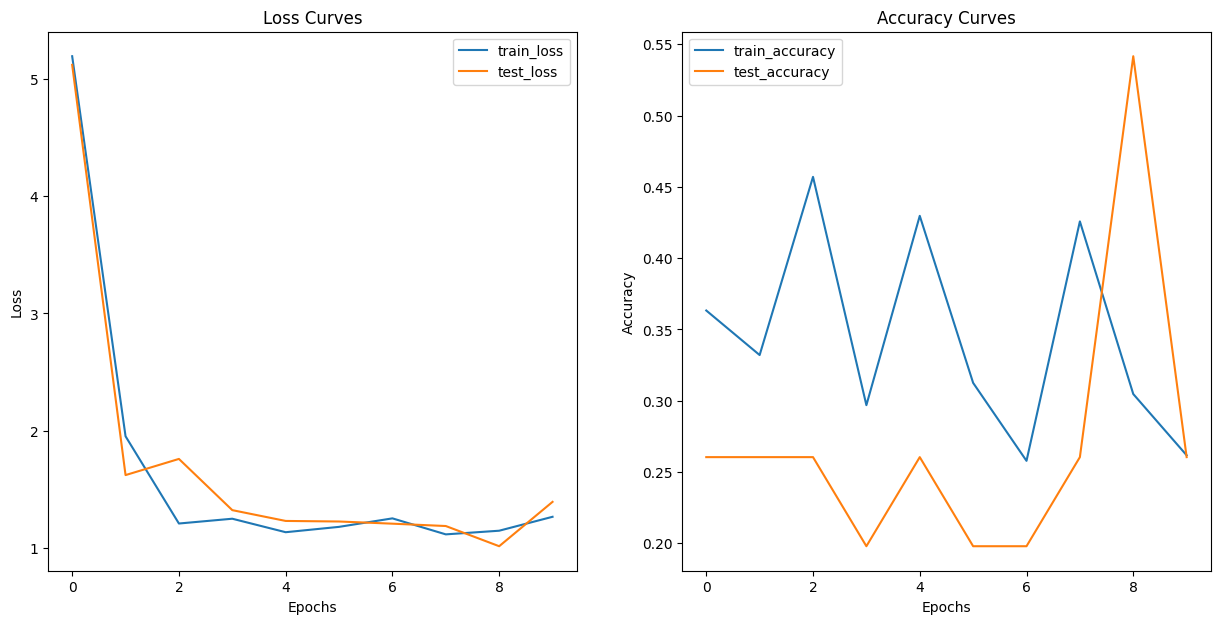

In [48]:
from typing import Tuple, Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
  # loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # accuracy values
  # move tensors to the CPU before converting to numpy
  train_accuracy = [tensor.cpu() for tensor in results['train_acc']]
  test_accuracy = [tensor.cpu() for tensor in results['test_acc']]

  # epochs as list
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label ='train_loss')
  plt.plot(epochs, test_loss, label ='test_loss')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')
  plt.title('Loss Curves')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label ='train_accuracy')
  plt.plot(epochs, test_accuracy, label ='test_accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

plot_loss_curve(results)